# Modeling void fraction in fluid channel using cross-sectional ellipses

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Wed April 29 17:07:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import shapely.affinity
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import unary_union

from descartes import PolygonPatch

np.random.seed(0)

def plot_channel(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

## Get images to model

Loaded image data:
['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


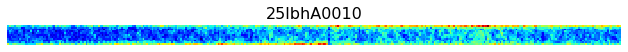

Shape: (11, 344), min: 43.13725490196078, max: 188.23529411764704


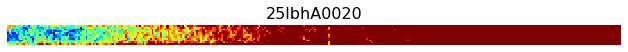

Shape: (11, 344), min: 115.68627450980392, max: 250.0


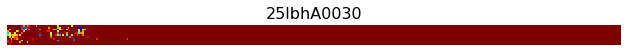

Shape: (11, 344), min: 210.7843137254902, max: 250.0


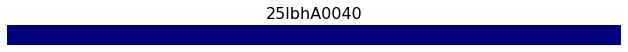

Shape: (11, 344), min: 250.0, max: 250.0


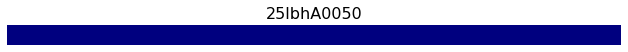

Shape: (11, 344), min: 250.0, max: 250.0


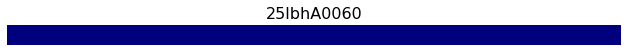

Shape: (11, 344), min: 250.0, max: 250.0


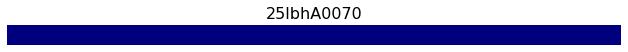

Shape: (11, 344), min: 250.0, max: 250.0


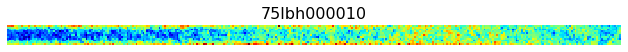

Shape: (11, 344), min: 39.21568627450981, max: 144.1176470588235


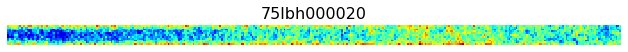

Shape: (11, 344), min: 41.1764705882353, max: 147.05882352941177


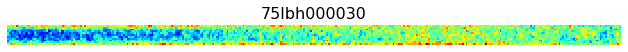

Shape: (11, 344), min: 39.21568627450981, max: 151.96078431372547


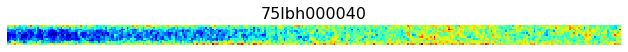

Shape: (11, 344), min: 55.88235294117647, max: 183.33333333333331


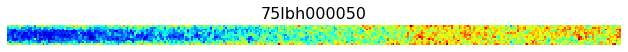

Shape: (11, 344), min: 61.76470588235294, max: 198.0392156862745


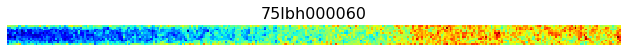

Shape: (11, 344), min: 58.8235294117647, max: 215.68627450980392


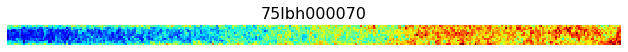

Shape: (11, 344), min: 75.49019607843137, max: 250.0


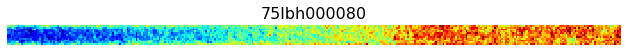

Shape: (11, 344), min: 76.47058823529413, max: 250.0


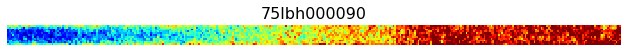

Shape: (11, 344), min: 91.17647058823529, max: 250.0


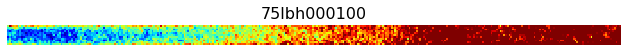

Shape: (11, 344), min: 102.94117647058823, max: 250.0


In [2]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print('Loaded image data:')
print(list(data))

# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    plot_channel(img, title=L)
    print('Shape: {}, min: {}, max: {}'.format(img.shape, img.min(), img.max()))

In [3]:
def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses) by taking
    # shapely multipolygon object and integrating over its profile to find cross section
    fit = []
    for c in range(len(cs['x'])):
        grid_points = np.column_stack((np.repeat(c, data['d_um']), np.arange(data['d_um'])))
        contains = [union.contains(Point(p)) for p in grid_points]
        fit.append(np.sum(contains))
    return union, fit

    
def get_ellipse_params(data, cs):
    """
    Get parameters of ellipses to populate channel with. Uses x and y for
    ellipse center and rx and ry for ellipse radii in each dimension.
    Returns list like [x1, y1, rx1, ry1, ... xn, yn, rxn, ryn]
    """
    # create 0th bubble: large in center of channel
    b0 = {
        'x': cs['x'].max()/2,
        'y': data['d_um']/2,
        'rx': cs['x'].max()/2,
        'ry': cs['cs'].min()/2}
    params = list(b0.values())
    
    # get starting points for subsequent bubbles. these are adjustable
    low_x = cs['x'].max()*1/8
    high_x = cs['x'].max()*7/8
    low_y = (b0['y'] - b0['ry'])/2
    high_y = (data['d_um'] + b0['y'] + b0['ry'])/2
    rx0 = low_x
    ry0 = (b0['y'] - b0['ry'])/2 * 5/6

    params += [
        low_x, low_y, rx0, ry0,
        low_x, high_y, rx0, ry0,
        high_x, low_y, rx0, ry0,
        high_x, high_y, rx0, ry0,
        
        low_x, low_y, rx0, ry0,
        low_x, high_y, rx0, ry0,
        high_x, low_y, rx0, ry0,
        high_x, high_y, rx0, ry0,
        
        b0['x'], low_y, rx0/2, ry0/2,
        b0['x'], high_y, rx0/2, ry0/2,
        b0['x'], low_y, rx0/2, ry0/2,
        b0['x'], high_y, rx0/2, ry0/2,
    ]

    return params

def clip_params(params, data, cs):
    """
    Clip ellipse parameters so that they fit inside the channel
    """
    for p in range(4, len(params), 4):
        params[p] = np.clip(params[p], 0, cs['x'].max())
        params[p+1] = np.clip(params[p+1], 0, data['d_um'])
        params[p+2] = np.clip(params[p+2], 0, 1+cs['x'].max()-params[p])
        params[p+3] = np.clip(params[p+3], 0, data['d_um']-params[p+1])
    return params

## Monte Carlo-based placement of ellipses in channel

pixel column 0/344


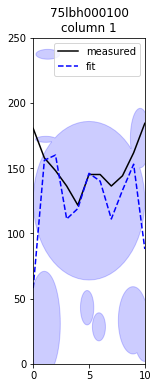

pixel column 1/344
pixel column 2/344
pixel column 3/344
pixel column 4/344
pixel column 5/344
pixel column 6/344
pixel column 7/344
pixel column 8/344
pixel column 9/344
pixel column 10/344
pixel column 11/344
pixel column 12/344
pixel column 13/344
pixel column 14/344
pixel column 15/344
pixel column 16/344
pixel column 17/344
pixel column 18/344
pixel column 19/344
pixel column 20/344
pixel column 21/344
pixel column 22/344
pixel column 23/344
pixel column 24/344
pixel column 25/344


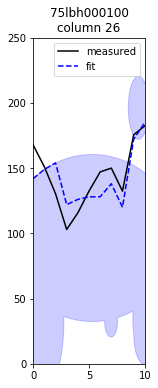

pixel column 26/344
pixel column 27/344
pixel column 28/344
pixel column 29/344
pixel column 30/344
pixel column 31/344
pixel column 32/344
pixel column 33/344
pixel column 34/344
pixel column 35/344
pixel column 36/344
pixel column 37/344
pixel column 38/344
pixel column 39/344
pixel column 40/344
pixel column 41/344
pixel column 42/344
pixel column 43/344
pixel column 44/344
pixel column 45/344
pixel column 46/344
pixel column 47/344
pixel column 48/344
pixel column 49/344
pixel column 50/344


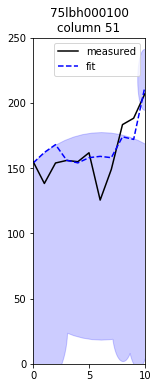

pixel column 51/344
pixel column 52/344
pixel column 53/344
pixel column 54/344
pixel column 55/344
pixel column 56/344
pixel column 57/344
pixel column 58/344
pixel column 59/344
pixel column 60/344
pixel column 61/344
pixel column 62/344
pixel column 63/344
pixel column 64/344
pixel column 65/344
pixel column 66/344
pixel column 67/344
pixel column 68/344
pixel column 69/344
pixel column 70/344
pixel column 71/344
pixel column 72/344
pixel column 73/344
pixel column 74/344
pixel column 75/344


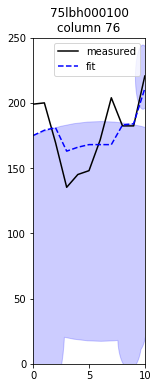

pixel column 76/344
pixel column 77/344
pixel column 78/344
pixel column 79/344
pixel column 80/344
pixel column 81/344
pixel column 82/344
pixel column 83/344
pixel column 84/344
pixel column 85/344
pixel column 86/344
pixel column 87/344
pixel column 88/344
pixel column 89/344
pixel column 90/344
pixel column 91/344
pixel column 92/344
pixel column 93/344
pixel column 94/344
pixel column 95/344
pixel column 96/344
pixel column 97/344
pixel column 98/344
pixel column 99/344
pixel column 100/344


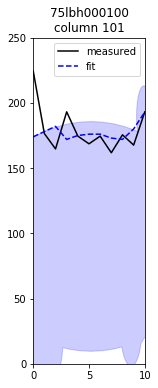

pixel column 101/344
pixel column 102/344
pixel column 103/344
pixel column 104/344
pixel column 105/344
pixel column 106/344
pixel column 107/344
pixel column 108/344
pixel column 109/344
pixel column 110/344
pixel column 111/344
pixel column 112/344
pixel column 113/344
pixel column 114/344
pixel column 115/344
pixel column 116/344
pixel column 117/344
pixel column 118/344
pixel column 119/344
pixel column 120/344
pixel column 121/344
pixel column 122/344
pixel column 123/344
pixel column 124/344
pixel column 125/344


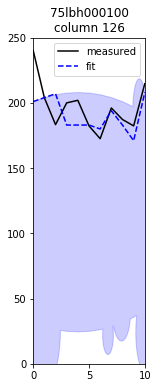

pixel column 126/344
pixel column 127/344
pixel column 128/344
pixel column 129/344
pixel column 130/344
pixel column 131/344
pixel column 132/344
pixel column 133/344
pixel column 134/344
pixel column 135/344
pixel column 136/344
pixel column 137/344
pixel column 138/344
pixel column 139/344
pixel column 140/344
pixel column 141/344
pixel column 142/344
pixel column 143/344
pixel column 144/344
pixel column 145/344
pixel column 146/344
pixel column 147/344
pixel column 148/344
pixel column 149/344
pixel column 150/344


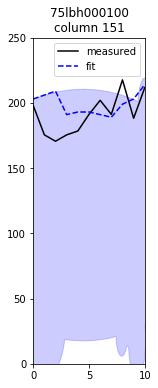

pixel column 151/344
pixel column 152/344
pixel column 153/344
pixel column 154/344
pixel column 155/344
pixel column 156/344
pixel column 157/344
pixel column 158/344
pixel column 159/344
pixel column 160/344
pixel column 161/344
pixel column 162/344
pixel column 163/344
pixel column 164/344
pixel column 165/344
pixel column 166/344
pixel column 167/344
pixel column 168/344
pixel column 169/344
pixel column 170/344
pixel column 171/344
pixel column 172/344
pixel column 173/344
pixel column 174/344
pixel column 175/344


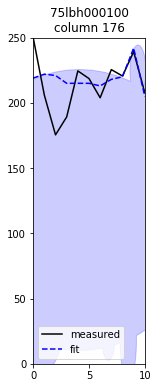

pixel column 176/344
pixel column 177/344
pixel column 178/344
pixel column 179/344
pixel column 180/344
pixel column 181/344
pixel column 182/344
pixel column 183/344
pixel column 184/344
pixel column 185/344
pixel column 186/344
pixel column 187/344
pixel column 188/344
pixel column 189/344
pixel column 190/344
pixel column 191/344
pixel column 192/344
pixel column 193/344
pixel column 194/344
pixel column 195/344
pixel column 196/344
pixel column 197/344
pixel column 198/344
pixel column 199/344
pixel column 200/344


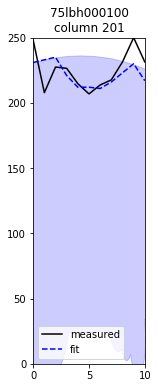

pixel column 201/344
pixel column 202/344
pixel column 203/344
pixel column 204/344
pixel column 205/344
pixel column 206/344
pixel column 207/344
pixel column 208/344
pixel column 209/344
pixel column 210/344
pixel column 211/344
pixel column 212/344
pixel column 213/344
pixel column 214/344
pixel column 215/344
pixel column 216/344
pixel column 217/344
pixel column 218/344
pixel column 219/344
pixel column 220/344
pixel column 221/344
pixel column 222/344
pixel column 223/344
pixel column 224/344
pixel column 225/344


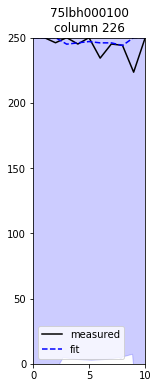

pixel column 226/344
pixel column 227/344
pixel column 228/344
pixel column 229/344
pixel column 230/344
pixel column 231/344
pixel column 232/344
pixel column 233/344
pixel column 234/344
pixel column 235/344
pixel column 236/344
pixel column 237/344
pixel column 238/344
pixel column 239/344
pixel column 240/344
pixel column 241/344
pixel column 242/344
pixel column 243/344
pixel column 244/344
pixel column 245/344
pixel column 246/344
pixel column 247/344
pixel column 248/344
pixel column 249/344
pixel column 250/344


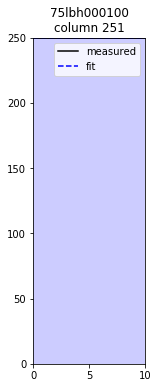

pixel column 251/344
pixel column 252/344
pixel column 253/344
pixel column 254/344
pixel column 255/344
pixel column 256/344
pixel column 257/344
pixel column 258/344
pixel column 259/344
pixel column 260/344
pixel column 261/344
pixel column 262/344
pixel column 263/344
pixel column 264/344
pixel column 265/344
pixel column 266/344
pixel column 267/344
pixel column 268/344
pixel column 269/344
pixel column 270/344
pixel column 271/344
pixel column 272/344
pixel column 273/344
pixel column 274/344
pixel column 275/344


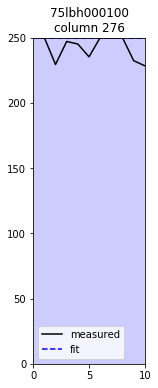

pixel column 276/344
pixel column 277/344
pixel column 278/344
pixel column 279/344
pixel column 280/344
pixel column 281/344
pixel column 282/344
pixel column 283/344
pixel column 284/344
pixel column 285/344
pixel column 286/344
pixel column 287/344
pixel column 288/344
pixel column 289/344
pixel column 290/344
pixel column 291/344
pixel column 292/344
pixel column 293/344
pixel column 294/344
pixel column 295/344
pixel column 296/344
pixel column 297/344
pixel column 298/344
pixel column 299/344
pixel column 300/344


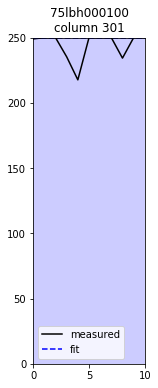

pixel column 301/344
pixel column 302/344
pixel column 303/344
pixel column 304/344
pixel column 305/344
pixel column 306/344
pixel column 307/344
pixel column 308/344
pixel column 309/344
pixel column 310/344
pixel column 311/344
pixel column 312/344
pixel column 313/344
pixel column 314/344
pixel column 315/344
pixel column 316/344
pixel column 317/344
pixel column 318/344
pixel column 319/344
pixel column 320/344
pixel column 321/344
pixel column 322/344
pixel column 323/344
pixel column 324/344
pixel column 325/344


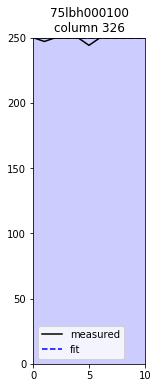

pixel column 326/344
pixel column 327/344
pixel column 328/344
pixel column 329/344
pixel column 330/344
pixel column 331/344
pixel column 332/344
pixel column 333/344
pixel column 334/344
pixel column 335/344
pixel column 336/344
pixel column 337/344
pixel column 338/344
pixel column 339/344
pixel column 340/344
pixel column 341/344
pixel column 342/344
pixel column 343/344


In [5]:
# number of iterations for testing bubble fitting configurations at each cross section
num_of_iterations = 100

# create dictionary for holding measured and simulated cross sections
cs = {'x': np.arange(img.shape[0]),
      'sim': np.zeros_like(img[:, 0]),
      'all_sim': np.zeros_like(img)}

# loop over each vertical cross section (column of pixels) of image
for col in range(img.shape[1]):
    
    print('pixel column {}/{}'.format(col, img.shape[1]))
    cs['cs'] = img[:, col]
    
    # for initial pixel column, iteratively find best initial bubble configuration
    if col == 0:
        # loop over small adjustments in the initial bubble parameters
        for it in range(num_of_iterations):
            if it == 0:
                # create initial bubble parameters
                params = get_ellipse_params(data, cs)
                best_params = params.copy()
                # get fit (simulated cross section after adding bubbles)
                union, cs['sim'] = multiellipse_fit(cs['x'], *params)
                # calculate residual of fit
                cs['residual'] = np.abs(np.subtract(cs['cs'], cs['sim']))
                best_residual = cs['residual'].mean()
            else:
                # add some random noise to parameters to see if it improves fit
                params = np.append([1,1,1,1], np.random.uniform(low=0.9, high=1.1, size=len(params)-4)) * best_params
                # filter out impossible parameters
                params = clip_params(params, data, cs)
                # get fit (simulated cross section after adding bubbles)
                union, cs['sim'] = multiellipse_fit(cs['x'], *params)
                # calculate residual of fit
                cs['residual'] = np.abs(np.subtract(cs['cs'], cs['sim']))
                # if these are the best fitting parameters so far, use them as the next params
                if cs['residual'].mean() < best_residual:
                    best_params = params
                    best_residual = cs['residual'].mean()
                    cs['all_sim'][:, col] = np.array(cs['sim'])
        all_bub_params = np.zeros((img.shape[1], len(params)))



    # after the first column, allow bubbles to change shape by 5% from the previous column
    if col > 0:
        previous_params = all_bub_params[col-1]
        best_params = previous_params.copy()
        best_residual = np.inf
        # loop over small changes in bubble configurations
        for it in range(num_of_iterations): 
            params = np.random.uniform(low=0.95, high=1.05, size=len(previous_params)) * previous_params
            params = clip_params(params, data, cs)
            union, cs['sim'] = multiellipse_fit(cs['x'], *params)
            # calculate residual of fit
            cs['residual'] = np.abs(np.subtract(cs['cs'], cs['sim']))
            # if these are better than previous fit parameters:
            if cs['residual'].mean() < best_residual:
                best_residual = cs['residual'].mean()
                best_params = params
                cs['all_sim'][:, col] = np.array(cs['sim'])

    # save parameters
    all_bub_params[col] = best_params

        
    # plot the results   
    if col % 25 == 0:
        fig, ax = plt.subplots()
        ax.add_patch(PolygonPatch(multiellipse_fit(cs['x'], *all_bub_params[col])[0],
                                  fc='b', ec='b', alpha=0.2))
        plt.plot(cs['x'], cs['cs'], c='k', label='measured')
        plt.plot(cs['x'], cs['all_sim'][:, col], c='b', linestyle='--', label='fit')
        fig.set_size_inches(2, 6)
        plt.xlim([0, np.max(cs['x'])]); plt.ylim([0, data['d_um']]); plt.legend()
        plt.title('{}\ncolumn {}'.format(L, col+1))
        #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
        plt.show()





### Reconstruct simulated channel

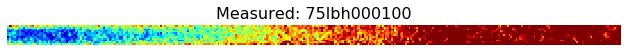

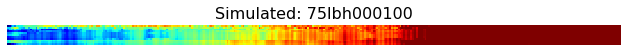

In [6]:
plot_channel(img, title='Measured: {}'.format(L), vmin=img.min(), vmax=img.max())
plot_channel(cs['all_sim'], title='Simulated: {}'.format(L), vmin=img.min(), vmax=img.max())

### Save bubble parameters to file

In [9]:
# save model parameters and cropped images to file
model_path = os.path.join(os.getcwd(), 'cross_section_ellipse_parameters.npy')
np.save(model_path, all_bub_params)

### Create video of bubble cross sections throughout channel

In [23]:
save_img_dir = os.path.join(os.getcwd(), 'cross_section_images')

for pi, p in enumerate(all_bub_params):
    
    if pi % 10 == 0:
        print('creating image {}/{}'.format(pi+1, len(all_bub_params)))
    
    union, sim_cross_sec = multiellipse_fit(cs['x'], *p)
    
    fig, ax = plt.subplots()
    ax.add_patch(PolygonPatch(multiellipse_fit(cs['x'], *p)[0], fc='b', ec='b', alpha=0.2))
    fig.set_size_inches(2, 6)
    
    plt.plot(cs['x'], img[:, pi], c='k', alpha=0.5, label='measured')
    plt.plot(cs['x'], sim_cross_sec, c='b', linestyle='--', label='fit', alpha=0.5)
    
    
    plt.xlim([0, np.max(cs['x'])]); plt.ylim([0, data['d_um']])
    plt.title('{}\ncross section {}'.format(L, pi+1))
    plt.legend()
    plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(pi).zfill(5))))
    #plt.show()
    plt.clf()
    plt.close()

creating image 1/344
creating image 11/344
creating image 21/344
creating image 31/344
creating image 41/344
creating image 51/344
creating image 61/344
creating image 71/344
creating image 81/344
creating image 91/344
creating image 101/344
creating image 111/344
creating image 121/344
creating image 131/344
creating image 141/344
creating image 151/344
creating image 161/344
creating image 171/344
creating image 181/344
creating image 191/344
creating image 201/344
creating image 211/344
creating image 221/344
creating image 231/344
creating image 241/344
creating image 251/344
creating image 261/344
creating image 271/344
creating image 281/344
creating image 291/344
creating image 301/344
creating image 311/344
creating image 321/344
creating image 331/344
creating image 341/344


In [25]:
import cv2
import glob

def create_video(image_folder, video_name, fps=8, reverse=False):
    """
    Create video out of images saved in a folder
    """
    images = [img for img in os.listdir(image_folder) if img.endswith('.jpg')]
    if reverse: images = images[::-1]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, fps, (width,height))
    for image in images:
        #print('wrote '+format(image))
        video.write(cv2.imread(os.path.join(image_folder, image)))
    video.release()
    #cv2.destroyAllWindows()



video_name = r'C:\Users\Eric\Desktop\channel_cross_sections_ellipses.avi'

make_video = True
if make_video:
    create_video(save_img_dir, video_name, fps=14)